# KLAUSMEIER MODEL
(https://www.science.org/doi/full/10.1126/science.284.5421.1826)

## ANALYSIS:
Klausmeier is one of the simplest way to model semi-ardid vegetation distribution:

$$
    \begin{cases}
    \partial_t w = a - w - wp^2 +\nu \partial_x w\\
    \partial_t p = wp^2 - mp + \Delta_{x,y}p
    \end{cases}
$$
(non-dimensionalised)

Where:
- $a$ is proportional to the water input (rain)
- $\nu$ is proportional to the slope of the terrain (in the x direction)
- $m$ is the biomass' mortality

The model is thought on some $\mathbb{R}^2$ square $[0,L]\times[0,L]$, with periodic buondaries.

The homogeneous solutions are found by solving:

$$
    \begin{cases}
        a-w-wp^2=0\\
        wp^2-mp=0
    \end{cases}
$$

which gives us:
$ (a,0) $ or

$$
    \begin{cases}
        w = \frac{a}{1+p^2}\\
        wp = m
    \end{cases}
$$

we can calculate $p$ from: $mp^2-ap+m=0$ so 

$$p=\frac{a\pm \sqrt{a^2-4m^2}}{2m}$$



From Klausmeier's paper: 

![alt text](klaus.png "Title")

Lets select some parameters that allow pattern formation:

In [8]:
import math
import cmath
import numpy as np 

a = 1.3      #rain
v = 182.5  #avg slope (actually water's speed downhill)
m = 0.45   #mortality

p1 = (a + math.sqrt(a**2 - (4*m**2)))/(2*m)
p2 = (a - math.sqrt(a**2 - (4*m**2)))/(2*m)

w1 = a/(1+p1**2)
w2 = a/(1+p2**2)

print("Sol. 1: {}".format((w1,p1)))
print("Sol. 2: {}".format((w2,p2)))


Sol. 1: (0.18095842401765705, 2.48675905773854)
Sol. 2: (1.119041575982343, 0.402129831150349)


Now we can study the "linear" stability associated to those points, so essentially the matrix:
$$
J(w_{eq},p_{eq})=
\begin{pmatrix}
        -1 -p_{eq}^2 & -2w_{eq}p_{eq} \\
        p_{eq}^2 & 2w_{eq}p_{eq}-m
\end{pmatrix}
$$

In [9]:
def stability(weq,peq):
    J = np.zeros((2,2))
    J[0,0] = -1 -peq**2
    J[0,1] = -2*weq*peq
    J[1,0] = peq**2
    J[1,1] = 2*weq*peq -m

    return (np.trace(J),np.linalg.det(J))

print(stability(w1,p1))
print(stability(w2,p2))


(-6.73397061124467, 2.332786775060101)
(-0.711708401101008, -0.3772312195045464)


So the first one is stable, while the second is not (for the reduced system).

Now we want to see if the first one becomes Turing-unstable, to do so we study a perturbed solution ($u(t,x,y)=u_0+\varepsilon(t,x,y)$) around an equilibria in the approximated PDE:

$$\partial_t \varepsilon\approx F(u_0)+JF(u_0)\varepsilon+\begin{pmatrix}\nu_0\partial_x \varepsilon_1\\\Delta \varepsilon\end{pmatrix}$$

which results in (by using the laplacian's eigenfunction with periodic boundaries: $e^{i(Mx+Ny)}\varepsilon(t)$ where $M,N\in \frac{2\pi}{L}\mathbb{N^2}$):

$$\partial_t \varepsilon = 
    \bigg[\begin{pmatrix}
        -1 -p_{eq}^2 & -2w_{eq}p_{eq} \\
        p_{eq}^2 & 2w_{eq}p_{eq}-m
    \end{pmatrix}
    +
    \begin{pmatrix}
        i\nu M & 0\\
        0 & -(M^2+N^2)
    \end{pmatrix} \bigg ] \begin{pmatrix}\varepsilon_1(t) \\ \varepsilon_2(t) \end{pmatrix}
$$

Now by calculating the 4 (2 for the real, 2 for the imag. part) eigenvalues associated to the overall matrix, and considering the function $f(M,N) = \max(\Re(\{\lambda_i(M,N)\}_i))$

The peak is:0.32072351881206895


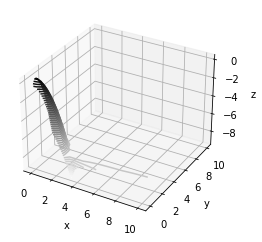

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

weq,peq = w1,p1

def complex_roots(z):
    r,phi = cmath.polar(z)
    return np.array([cmath.rect(math.sqrt(r),phi/2),cmath.rect(math.sqrt(r),phi/2+cmath.pi)])

def F(x,y): #calculates the eigenvalues of (JF+D)
    k = 1
    
    J = np.zeros((2,2),dtype=complex)
    J[0,0] = complex(-1-peq**2,v*x)
    J[0,1] = complex(-2*weq*peq,0)
    J[1,0] = complex(peq**2)
    J[1,1] = complex(2*weq*peq-m-(x**2+y**2),0)

    Tr = np.trace(J)
    det = np.linalg.det(J)

    g_p = (Tr+complex_roots(Tr**2-4*det))/2
    g_m = (Tr-complex_roots(Tr**2-4*det))/2


    return np.concatenate((g_p,g_m))

def f(X,Y):
    Z = np.zeros((len(X),len(Y)))

    for i in range(len(X)):
        for j in range(len(Y)):
            Z[i,j] = np.max(F(X[i],Y[j]).real)

    return Z

x = np.linspace(0, 10, 30)
y = np.linspace(0, 10, 30)

X, Y = np.meshgrid(x, y)
Z = f(x, y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

print("The peak is:{}".format(Z.max()))
plt.show()

Hence, for some choice of the domain's parameter ($L$), we might have a Turing-like instability.
By plotting this same graph for different choices of the parameters, we can get a fuller picture of the model.

A similar analysis shows that the equilibria $(a,0)$ cannot be Turing-unstable, which makes perfect sense, since all the water evaporates, so even if we start with some biomass it will soon die.

## SIMULATION:
To run the simulation lets use the method of lines:

$$
\partial_x p \approx \frac{p(x+h,y)-p(x,y)}{h}
$$
and
$$
\partial^2_{x^2} p \approx \frac{p(x+h,y)-2p(x,y)+p(x-h,y)}{h^2}
$$

which turns the PDE into an ODE.<br>
(To solve the ODE then, we are going to use Euler's method)

Simulation's parameters:

In [15]:
H = W =100   #points on the grid
h = 1        #space time step
dt = 0.005   #time step
N = 4000     #iterations

Initial conditions:

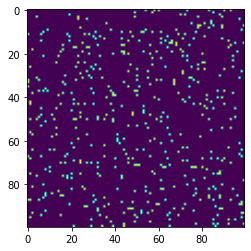

In [12]:
w = np.zeros((H,W)) + 0.1 
p = (np.random.random((H,W))<0.05)*1+1  
plt.imshow(p)
plt.show()

The value 0.1 (which is close to the equilibria), has been selected such that it converges more quickly.

While for the plants we set a base level of 1, so some kind of base plant distribution, and then in few (rare spots), we rise the concentration to 2.

Now we could calculate the derivatives in runtime, but it's way more efficient to use matrices:


In [13]:
def d_x(J):
    return (np.roll(J,1,axis=1) - J)/h


def nabla(J):
    Ju = np.roll(J,-1,axis=0)
    Jd = np.roll(J,+1,axis=0)
    
    Jr = np.roll(J,+1,axis=1)
    Jl = np.roll(J,-1,axis=1)
    
    return (Ju+Jd+Jr+Jl-4*J)/(h**2)

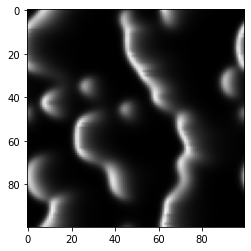

In [16]:
for iter in range(0,N):
    
    ##matrix:
    nabla_p = nabla(p)
    der_w = d_x(w)
    
    #EULER:
    
    w = w + dt*(a - w - (w*p*p) + v * der_w)
    p = p + dt*((w*p*p) - m*p + nabla_p )
    
    
    if np.max(w) > 10e+40: #in case algorithmic instabilities occur
        print("exeunt")
        break
        
    
    clear_output(wait=True)
    plt.imshow(p, cmap='gray')
    plt.show()

As opposed to classical Turing morphogenesis, we can see that the patterns move uphill.

This was explained by Klausmeier: when rain flows downhill it gets absorbed first by the plants at the top of the strip, while the ones at the bottom get less and will eventually die out.

An interesting phenomena that can be noticed by running the simulations is: 

the distance between the strips increases as we decrease $a$, in fact by imposing wave-like solutions fo the simplfied model (1 spatial dimension only):
$$
    \begin{cases}
    -c\dot \omega = a - \omega - \omega\pi^2+\nu\dot\omega \\
    -c\dot \pi = \omega\pi^2-m\pi+\ddot\pi
    \end{cases}
$$

where $w = \omega(x-ct)\text{ and }p = \pi(x-ct)$

imposing the condition for a Hopf bifurcation (since the train waves will form a cycle in the $(\omega,\pi)$ plane) and with $\nu>>1$, we get:

$$
    c \propto \frac{\nu m^3}{a^2}
$$

And this gives us the wavelength $\lambda = \frac{c}{f}$.

This means that we can read the environment back and guess the rainfall!
